<a href="https://colab.research.google.com/github/komingsu/Kaggle---HuBMAP-HPA/blob/main/Modeling/Model_Improvement/model_change_deeplabv3%2B_proceeding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils, layers, models, applications
from tensorflow._api.v2.image import ResizeMethod

In [51]:
# Entry Flow

def entry_flow(x) : 
  y = layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2))(x)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.Conv2D(filters = 64, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)

  r = layers.Conv2D(128, kernel_size = (1,1), strides = (2,2))(y)

  y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3), strides = (2,2))(y)

  # residual과 resolution이 약간 달라서 reshape
  y = layers.Resizing(r.shape[1], r.shape[2])(y)
  z1 = tf.concat([y,r],-1)
  z1 = layers.BatchNormalization()(z1)
  z1 = layers.Activation('relu')(z1)


  r = layers.Conv2D(256, kernel_size = (1,1), strides = (2,2))(z1)

  y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3))(z1)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3), strides = (2,2))(y)
  y = layers.Resizing(r.shape[1], r.shape[2])(y)

  z = tf.concat([y,r],-1)
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)

  r = layers.Conv2D(728, kernel_size = (1,1), strides = (2,2))(z)

  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(z)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3), strides = (2,2))(y)
  y = layers.Resizing(r.shape[1], r.shape[2])(y)

  z = tf.concat([y,r],-1)
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)

  return z,z1


In [52]:
# Middle flow

def middle_flow(x) :
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(x)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y) 
  y = layers.Resizing(x.shape[1], x.shape[2])(y)

  z = tf.concat([y,x],-1)
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)
  return z

In [53]:
# Exit flow

def exit_flow(x) :
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(x)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 1024, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 1024, kernel_size = (3,3), strides = (2,2))(y)
  x = layers.SeparableConv2D(filters = 1024, kernel_size = (1,1), strides = (1,1))(x)
  y = layers.Resizing(x.shape[1], x.shape[2])(y)


  z = tf.concat([y,x],-1)
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)

  y = layers.SeparableConv2D(filters = 1536, kernel_size = (3,3))(z)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 1536, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 2048, kernel_size = (3,3))(y)
  return y  

In [54]:
def decoder(low_img, aspp_img) :
  from tensorflow._api.v2.image import ResizeMethod
  low_level_img = layers.Conv2D(2048, kernel_size = (1,1))(low_img)   # ASPP 통과한 이미지와 채널 수 맞춤

  size = (low_img.shape[1],low_img.shape[2]) # resize img
  ASPP_img = tf.image.resize(aspp_img, size = size, method = ResizeMethod.BILINEAR)    # low level 이미지와 ASPP 통과한 이미지 resolution 맞춤

  concat_img = tf.concat([low_level_img, ASPP_img], axis = -1)

  concat_img = layers.Conv2D(2, kernel_size = (3,3))(concat_img)
  img = tf.image.resize(concat_img, size = (3000,3000), method = ResizeMethod.BILINEAR)

  return img

In [55]:
# optimizer
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# loss
def weighted_loss(y_true, y_pred):
# Calculate the base loss
  from tensorflow.keras.losses import binary_crossentropy
  bc = binary_crossentropy(y_true, y_pred)
  # Apply the weights
  one_weight = 1.0
  zero_weight = 1e-2
  weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
  weight_vector = K.squeeze(weight_vector, axis=-1)
  weighted_ce = weight_vector * bc
  # Return the mean error
  return K.mean(weighted_ce)

In [56]:
def deeplabv3(input_shape) :
  x = layers.Input(input_shape)
  z, low_level_feature = entry_flow(x)
  z = middle_flow(z)
  ASPP_feature = exit_flow(z)
  output =  decoder(low_level_feature, ASPP_feature)
  model = models.Model(x, output)
  model.compile(loss=weighted_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy', dice_coef])
  return model

In [60]:
input_shape = (3000,3000,1)
model = deeplabv3(input_shape)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 3000, 3000,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, 1499, 1499,   320         ['input_23[0][0]']               
                                32)                                                               
                                                                                                  
 batch_normalization_201 (Batch  (None, 1499, 1499,   128        ['conv2d_94[0][0]']              
 Normalization)                 32)                                                         

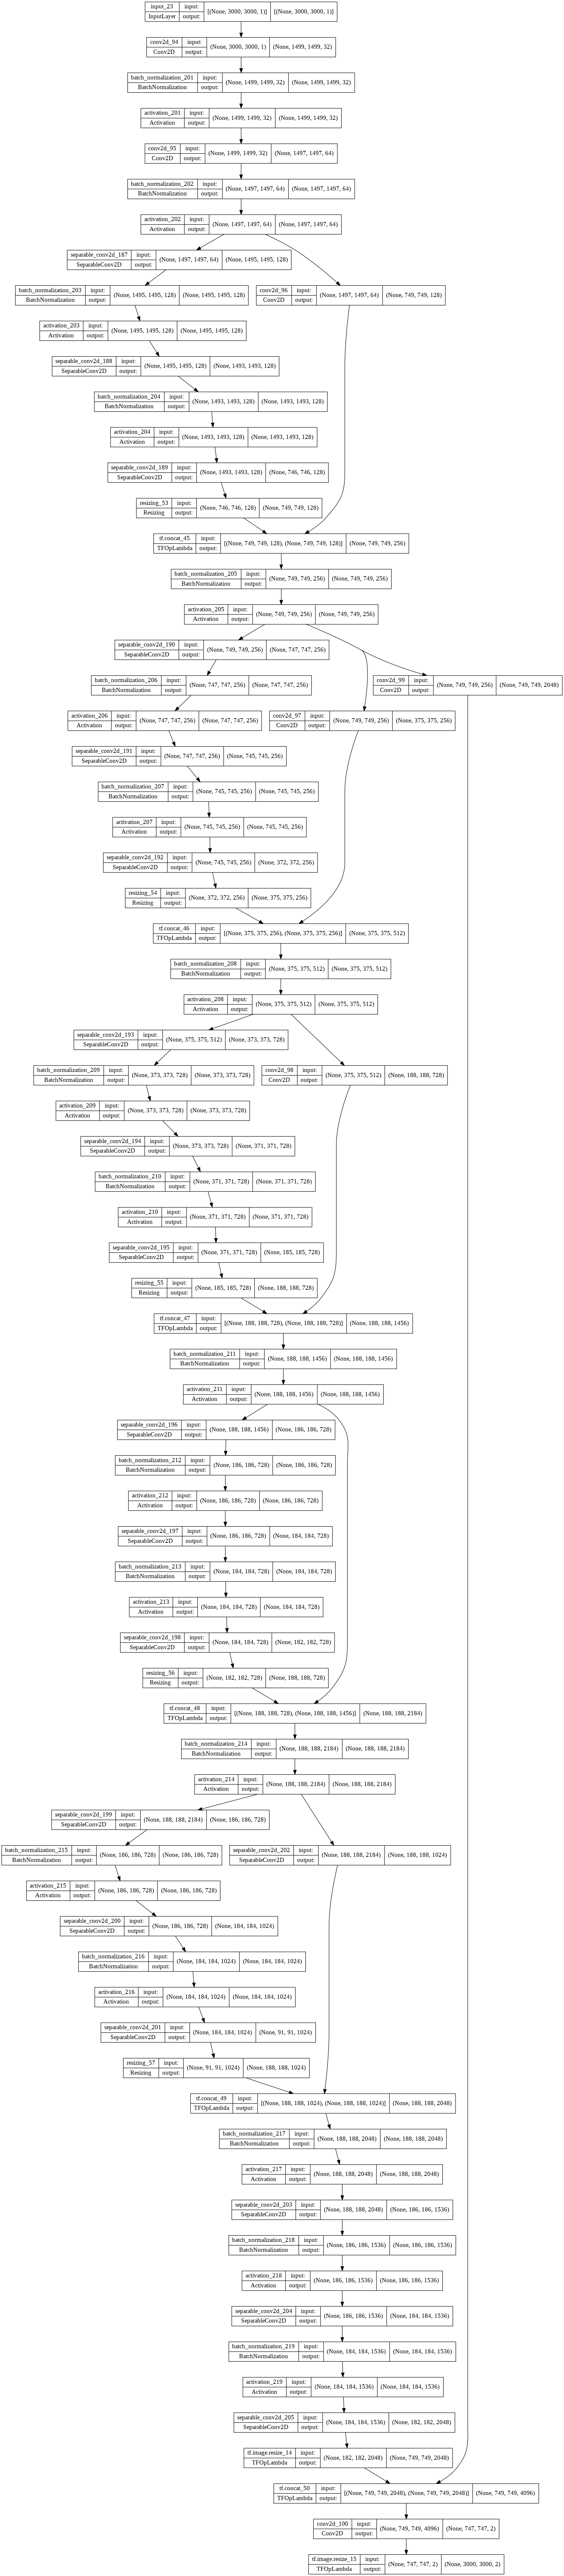

In [61]:
tf.keras.utils.plot_model(model, show_shapes = True)